In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'WD_Kernel': WeightedDegree_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

log_flag = True

In [3]:
# setting

cv = 5
test_size = 0.2
random_state = 24
embedding = 'label'
eva_on_ave_flag = True # true label is the sample mean instead of individual samples, since the prediction is the posterior mean
eva_metric = mean_squared_error # mean square error returns a more stable optimal hyparameter choice than r2 score

kernel = 'WD_Kernel_Shift'
alpha = 0.5
l = [6]
b = 0.33

weight_flag = False
padding_flag = False
gap_flag = False
plot_format = 'plt'

In [17]:
Path = '../../data/firstRound_4h_normTrue_formatSeq_logTrue.csv'

df_frr = pd.read_csv(Path)
df_frr.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,1.866788,0.255154
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.181122,NaN,1.309597,1.693182,1.394633,0.266411
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.700778,NaN,0.331062,0.493596,0.508479,0.185307
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.287142,NaN,1.156889,1.356925,1.266986,0.101530
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,1.379619,NaN,1.406433,1.374056,1.386702,0.017312
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,NaN,0.304483,NaN,0.070532,0.245348,0.206788,0.121649
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,NaN,1.000331,NaN,0.682767,1.019584,0.900894,0.189149
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,NaN,1.185658,NaN,1.442020,1.386894,1.338191,0.134942
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,NaN,0.614593,NaN,0.304789,0.313356,0.410912,0.176444
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,NaN,0.803114,NaN,1.137199,1.009548,0.983287,0.168584


(array([ 8.,  4., 16., 17., 14., 28., 28., 21., 11.,  3.]),
 array([-2.22735111, -1.80378607, -1.38022104, -0.956656  , -0.53309097,
        -0.10952594,  0.3140391 ,  0.73760413,  1.16116916,  1.5847342 ,
         2.00829923]),
 <a list of 10 Patch objects>)

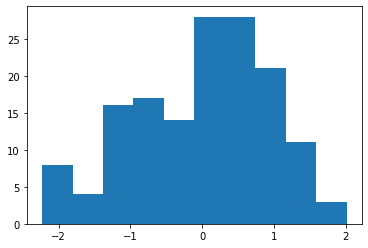

In [18]:
plt.hist(df_frr['AVERAGE'])

In [20]:
frr_rbs_set = set(df_frr['RBS'])

## Create test dataset

In [12]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in itertools.product(char_sets, repeat= design_len):
    
    combo = pre_design + ''.join(combo) + pos_design
    combos_6.append(''.join(combo))
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len
# len(combos)

In [23]:
df = pd.DataFrame()
df['RBS'] = list(set(combos) - frr_rbs_set)
#df['AVERAGE'] = NaN

In [24]:
df

,RBS
0,TTTAAGAAGTCTGTATACAT
1,TTTAAGACCCTCGTATACAT
2,TTTAAGATCCAGGTATACAT
3,TTTAAGATGAAGTTATACAT
4,TTTAAGATTCGATTATACAT
...,...
3982,TTTAAGAAGTCCCTATACAT
3983,TTTAAGACTAGCATATACAT
3984,TTTAAGATGACTTTATACAT
3985,TTTAAGACTTAATTATACAT


## Test

In [6]:
gpr = GPR_Predictor(df, test_size=test_size, kernel_name=kernel,alpha=alpha, embedding='label',
                   eva_metric=eva_metric, l_list=l, s = 0)

In [7]:
gpr.regression()

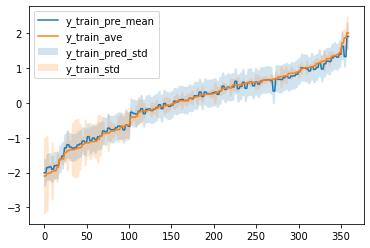

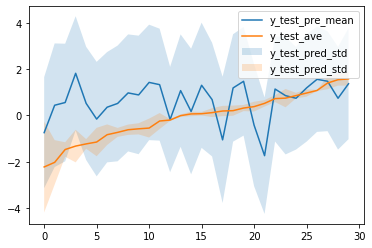

In [8]:
gpr.line_plot()

In [10]:
result = gpr.Repeated_kfold(num_repeat = 2)

In [11]:
result

<xarray.DataArray (train_test: 2, alpha: 2, l: 1, s: 1, num_repeat: 2, num_split: 5)>
array([[[[[[0.01709906, 0.02918113, 0.01908481, 0.00787043,
            0.00920212],
           [0.00839803, 0.00951455, 0.01529508, 0.03421417,
            0.01439635]]]],



        [[[[0.13484569, 0.13296932, 0.11186869, 0.09627962,
            0.09362713],
           [0.113449  , 0.12715525, 0.09944942, 0.10018349,
            0.11147865]]]]],




       [[[[[2.24473801, 1.94966039, 1.64595803, 2.16029157,
            3.61587889],
           [1.97451889, 2.38472744, 2.19728991, 2.21897852,
            1.89682322]]]],



        [[[[1.21943899, 0.86907321, 0.96025906, 1.29386168,
            1.8168987 ],
           [1.09484793, 1.03872188, 1.30372798, 1.25071159,
            1.20225609]]]]]])
Coordinates:
  * train_test  (train_test) <U5 'Train' 'Test'
  * alpha       (alpha) float64 0.1 1.0
  * l           (l) <U3 '[3]'
  * s           (s) int64 0
  * num_repeat  (num_repeat) int64 0 1
  * num_split   (num_split) int64 0 1 2 3 4
Attributes:
    eva_metric:  <function mean_squared_error at 0x7f9f77706840>